# Deep Learning Project- Gesture Recognition

### Problem Statement
As a data scientist at a home electronics company which manufactures state of
the art smart televisions. We want to develop a cool feature in the smart-TV
that can recognise five different gestures performed by the user which will
help users control the TV without using a remote. 



### Mounting Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# current working directory
pwd

'/content'

In [ ]:
# working directory path for gesture recognition 
cd /content/drive/MyDrive/Gesture Recognition

/content/drive/MyDrive/Gesture Recognition


### Importing relevent libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import random as rn
import os

# from imageio import imread
import cv2
import matplotlib.pyplot as plt
#% matplotlib inline
import datetime
import time

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, GlobalAveragePooling3D, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.layers import Dropout
from keras.applications import mobilenet
from keras import backend as K
from PIL import Image, ImageFilter, ImageEnhance

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# specifying path for data folder
data_folder = 'Project_data'
# saving the training csv file in a dataframe
data_train= pd.read_csv(data_folder + '/train.csv',sep = ';',header = None,names = ['video_name','class','label'])
data_train.head(2)
# saving the test csv file in a dataframe
data_test= pd.read_csv(data_folder + '/val.csv',sep = ';',header = None,names = ['video_name','class','label'])

In [ ]:
data_test.head()

,video_name,class,label
0,WIN_20180925_17_17_04_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_43_01_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_18_01_40_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_18_03_21_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180926_16_46_22_Pro_Left_Swipe_new,Left_Swipe_new,0


In [ ]:
data_train.label.value_counts()

1    137
3    137
0    136
2    130
4    123
Name: label, dtype: int64

In [ ]:
# mapping label names in correct format
data_train['label_class'] = data_train['label'].map({ 1:'right_swipe',
                                         0:'left_swipe',
                                         2:'Stop',
                                         3:'thumbs_down',
                                         4:'thumbs_up'})
data_test['label_class'] = data_test['label'].map({ 1:'right_swipe',
                                         0:'left_swipe',
                                         2:'Stop',
                                         3:'thumbs_down',
                                         4:'thumbs_up'})

In [ ]:
data_test.label_class.value_counts().sum(),len(data_test)

(100, 100)

In [ ]:
data_train.head(5)

,video_name,class,label,label_class
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0,left_swipe
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0,left_swipe
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0,left_swipe
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0,left_swipe
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0,left_swipe


In [ ]:
# dropping the class name and keeping the label name for both train and test dataframe
data_test.drop(['class'],inplace = True,axis = 1)
data_train.drop(['class'],inplace = True,axis = 1)

In [ ]:
# specifying batch size and dimensions of the image
batch_size = 32
x_dim = 100   # X 
y_dim = 100  # Y 

### Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
## function to plot model results


def plot_results(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    plt.show()


In [ ]:
def generator(source_path, df, batch_size,x_dims,y_dims, is_train = False, augmention = False):
    # '''
    # folder_list : replace with data frame
    # source_path : train/val

    # '''
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(0,30,2)#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = x_dims, y_dims
    while True: 
        df = df.sample(frac = 1).reset_index(drop=True)
        df_index = 0

        num_batches = len(df)//batch_size# calculate the number of batches
        remaining_items = len(df)%batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size

                # imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                imgs  = os.listdir(source_path+'/'+df.iloc[df_index]['video_name'])
                # print(df_index)
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.imread(source_path+'/'+df.iloc[df_index]['video_name']+'/'+imgs[item])
                    # print(os.path.exists(source_path+'/'+imgs[item]),source_path+'/'+imgs[item])
                    image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    ### cropping image sqaure image to maintain aspect ratio while resizing
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]
                    
                      
                    resized_im =  cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)
                    # using augmentation 
                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))


                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image
                batch_labels[folder, df.iloc[df_index]['label']] = 1
                df_index+=1
            # print("batch labels length",batch_labels.shape)
            # print("batch_data",batch_data.shape)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        ### dealing with remaining items 

        ### 4 ,2 
        batch_data = np.zeros((remaining_items,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_items,5))
        for folder in range(remaining_items):

          # for folder in range(remaining_items):
            imgs = os.listdir(source_path+'/'+df.iloc[df_index]['video_name'])

            aug_type = None
            if is_train and augmention and rn.randint(0,1) == 1:
                aug_type = rn.randint(0, 4) #randomly selecting augmentation type
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                # image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image = cv2.imread(source_path+'/'+df.iloc[df_index]['video_name']+'/'+imgs[item])
                # print(os.path.exists(source_path+'/'+imgs[item]),source_path+'/'+imgs[item])
                image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                ### cropping image sqaure image to maintain aspect ratio while resizing
                if image.shape[1] > image.shape[0]:
                    diff_px = image.shape[1] - image.shape[0]
                    crop_start = diff_px//2
                    crop_end = crop_start + image.shape[0]
                    image = image[:, crop_start:crop_end]
                elif image.shape[0] > image.shape[1]:
                    diff_px = image.shape[0] - image.shape[1]
                    crop_start = diff_px//2
                    crop_end = crop_start + image.shape[1]
                    image = image[:, crop_start:crop_end]
                    
                  
                resized_im =  cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)

                if aug_type is not None:
                    if aug_type == 0: # edge Enhancement
                        resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                    elif aug_type == 1: # adding gaussian blur
                        resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                    elif aug_type == 2: # enchancing image detailing
                        resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                    elif aug_type == 3: # sharpening image
                        resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                    elif aug_type == 4: # Brightness enhancement
                        resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # print()
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image
            batch_labels[folder, df.iloc[df_index]['label']] = 1
            df_index+=1
        # print("batch labels length",batch_labels.shape)
        # print("batch_data",batch_data.shape)
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### Visualizing the images stored in a particular folder

In [ ]:
k = os.listdir('Project_data/train/WIN_20180925_17_08_43_Pro_Left_Swipe_new')

In [ ]:
image1 = cv2.imread('Project_data/train/WIN_20180925_17_08_43_Pro_Left_Swipe_new/'+k[5])
image = cv2.imread('Project_data/train/WIN_20180925_17_08_43_Pro_Left_Swipe_new/'+k[5])

image =  cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image =  cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)

Populating the interactive namespace from numpy and matplotlib


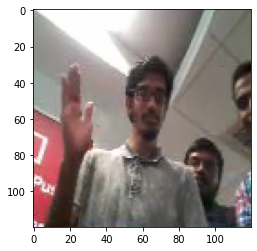

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# img = mpimg.imread('your_image.png')
imgplot = plt.imshow(image)
plt.show()

Populating the interactive namespace from numpy and matplotlib


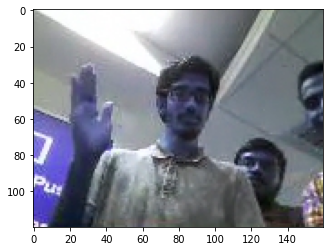

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# img = mpimg.imread('your_image.png')
imgplot = plt.imshow(image1)
plt.show()

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(data_train)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(data_test)
print('# validation sequences =', num_val_sequences)
batch_size = 32
print("# batch size",batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size 32


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Model 1: Conv3D with dropouts and batch normalization with EarlyStopping

In [ ]:
# specifying input image dimensions 
input_shape = (15, x_dim, y_dim, 3)

model = Sequential()

model.add(Conv3D(16, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
# writing the optimizer
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# printing the summary for the above model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 13, 98, 98, 16)    1312      
                                                                 
 conv3d_13 (Conv3D)          (None, 11, 96, 96, 32)    13856     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 48, 48, 32)    0         
 3D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 5, 48, 48, 32)    128       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 5, 48, 48, 32)     0         
                                                                 
 conv3d_14 (Conv3D)          (None, 3, 46, 46, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
Not using augmentation for validaton data

In [ ]:
batch_size= 32
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR, early_stopping]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.6649 - categorical_accuracy: 0.3318 Source path =  Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.64285, saving model to Model_Gesture_Recog1_2022-08-1508_03_58.129613/model-00001-1.66493-0.33183-1.64285-0.26000.h5
21/21 [==============================] - 1051s 52s/step - loss: 1.6649 - categorical_accuracy: 0.3318 - val_loss: 1.6428 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.3119 - categorical_accuracy: 0.4615
Epoch 2: val_loss did not improve from 1.64285
21/21 [==============================] - 50s 3s/step - loss: 1.3119 - categorical_accuracy: 0.4615 - val_loss: 1.7530 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.2083 - categorical_accuracy: 0.4992
Epoch 3: val_loss improved from 1.64285

##### Results from Model 1
- CNN-3D with early stopping 
- Epochs Used - 50
- Training accuracy- 60%
- Validation accuracy - 34%
- Early stopping at 14 epoch
- Model is overfitting

#### Model 2: conv3D with Dropouts and BatchNormalization with no Early Stopping. Also increase in number of input channels.

In [ ]:
input_shape = (15, x_dim, y_dim, 3)

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 13, 98, 98, 32)    2624      
                                                                 
 conv3d_17 (Conv3D)          (None, 11, 96, 96, 64)    55360     
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 5, 48, 48, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 5, 48, 48, 64)    256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 5, 48, 48, 64)     0         
                                                                 
 conv3d_18 (Conv3D)          (None, 3, 46, 46, 128)   

In [ ]:
batch_size= 32
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.7166 - categorical_accuracy: 0.3439Source path =  Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 2.59565, saving model to Model_Gesture_Recog2_2022-08-1508_03_58.129613/model-00001-1.71656-0.34389-2.59565-0.21000.h5
21/21 [==============================] - 53s 3s/step - loss: 1.7166 - categorical_accuracy: 0.3439 - val_loss: 2.5957 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.3263 - categorical_accuracy: 0.4465
Epoch 2: val_loss improved from 2.59565 to 1.74937, saving model to Model_Gesture_Recog2_2022-08-1508_03_58.129613/model-00002-1.32633-0.44646-1.74937-0.24000.h5
21/21 [==============================] - 50s 2s/step - loss: 1.3263 - categorical_accuracy: 0.4465 - val_loss: 1.7494 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/50
21/21 [================

In [ ]:
history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.1711 - categorical_accuracy: 0.9532
Epoch 1: val_loss did not improve from 0.64961
21/21 [==============================] - 51s 3s/step - loss: 0.1711 - categorical_accuracy: 0.9532 - val_loss: 0.7936 - val_categorical_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.1464 - categorical_accuracy: 0.9638
Epoch 2: val_loss did not improve from 0.64961
21/21 [==============================] - 50s 2s/step - loss: 0.1464 - categorical_accuracy: 0.9638 - val_loss: 0.8530 - val_categorical_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.1474 - categorical_accuracy: 0.9563
Epoch 3: val_loss did not improve from 0.64961
21/21 [==============================] - 51s 3s/step - loss: 0.1474 - categorical_accuracy: 0.9563 - val_loss: 0.9105 - val_categorical_accuracy: 0.6700 - lr: 1.0000e-04
Epoch 4/30
21/21 [=============

##### Results from Model 2:
- Increase in number of input channels
- No Early Stopping
- Increasing number of units for Dense Layer
- Training accuracy - 93%
- Validation accuracy- 80%
- Model with more parameters

#### Model 3: conv3D with more layers

In [ ]:
input_shape = (15, x_dim, y_dim, 3)

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 13, 98, 98, 32)    2624      
                                                                 
 conv3d_21 (Conv3D)          (None, 11, 96, 96, 64)    55360     
                                                                 
 batch_normalization_20 (Bat  (None, 11, 96, 96, 64)   256       
 chNormalization)                                                
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 48, 48, 64)    0         
 g3D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 5, 48, 48, 64)     0         
                                                                 
 conv3d_22 (Conv3D)          (None, 3, 46, 46, 128)   

In [ ]:
batch_size= 32
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=80, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 32
Epoch 1/80
21/21 [==============================] - ETA: 0s - loss: 1.7777 - categorical_accuracy: 0.3062Source path =  Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 2.09965, saving model to Model_Gesture_Recog3_2022-08-1508_03_58.129613/model-00001-1.77772-0.30618-2.09965-0.23000.h5
21/21 [==============================] - 54s 3s/step - loss: 1.7777 - categorical_accuracy: 0.3062 - val_loss: 2.0997 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/80
21/21 [==============================] - ETA: 0s - loss: 1.5229 - categorical_accuracy: 0.3816
Epoch 2: val_loss improved from 2.09965 to 1.58653, saving model to Model_Gesture_Recog3_2022-08-1508_03_58.129613/model-00002-1.52292-0.38160-1.58653-0.27000.h5
21/21 [==============================] - 52s 3s/step - loss: 1.5229 - categorical_accuracy: 0.3816 - val_loss: 1.5865 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/80
21/21 [================

##### Results form Model 3:
- Decrese in number of units for Dense layers
- Increasing number of layers
- Training accuracy- 92%
- Val Accuracy - 80%

#### Model 4: conv3D with more Dense layers

In [ ]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

#model.add(GlobalAveragePooling3D())
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 7, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 7, 50, 50, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 7, 50, 50, 32)     0         
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 3, 25, 25, 32)    0         
 g3D)                                                 

In [ ]:
batch_size= 32
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=80, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 32
Epoch 1/80
21/21 [==============================] - ETA: 0s - loss: 1.6140 - categorical_accuracy: 0.2112Source path =  Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.58429, saving model to Model_Gesture_Recog4_2022-08-1508_03_58.129613/model-00001-1.61404-0.21116-1.58429-0.23000.h5
21/21 [==============================] - 53s 3s/step - loss: 1.6140 - categorical_accuracy: 0.2112 - val_loss: 1.5843 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/80
21/21 [==============================] - ETA: 0s - loss: 1.5699 - categorical_accuracy: 0.2715
Epoch 2: val_loss improved from 1.58429 to 1.46190, saving model to Model_Gesture_Recog4_2022-08-1508_03_58.129613/model-00002-1.56985-0.27149-1.46190-0.36000.h5
21/21 [==============================] - 50s 3s/step - loss: 1.5699 - categorical_accuracy: 0.2715 - val_loss: 1.4619 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 3/80
21/21 [================

##### Results from Model 4:
- Training Accuracy- 88%
- Val accuracy - 81%
- Without batch normalization
- Increase Dense Layers
- Less overfitting

#### Model 5: conv2D + GRU using BatchNormalization. No Dropouts

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 98, 98, 32)   896       
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 49, 49, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_26 (Bat  (None, 15, 49, 49, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 47, 47, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 23, 23, 64) 

In [ ]:
batch_size= 32
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.2770 - categorical_accuracy: 0.4661Source path =  Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.60537, saving model to Model_Gesture_Recog5_2022-08-1508_03_58.129613/model-00001-1.27701-0.46606-1.60537-0.23000.h5
21/21 [==============================] - 51s 3s/step - loss: 1.2770 - categorical_accuracy: 0.4661 - val_loss: 1.6054 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.1207 - categorical_accuracy: 0.5596
Epoch 2: val_loss improved from 1.60537 to 1.59984, saving model to Model_Gesture_Recog5_2022-08-1508_03_58.129613/model-00002-1.12074-0.55958-1.59984-0.32000.h5
21/21 [==============================] - 50s 2s/step - loss: 1.1207 - categorical_accuracy: 0.5596 - val_loss: 1.5998 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.0100 - categoric

In [ ]:
history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.4595 - categorical_accuracy: 0.8356
Epoch 1: val_loss improved from 0.84884 to 0.71959, saving model to Model_Gesture_Recog5_2022-08-1508_03_58.129613/model-00001-0.45954-0.83560-0.71959-0.74000.h5
21/21 [==============================] - 50s 2s/step - loss: 0.4595 - categorical_accuracy: 0.8356 - val_loss: 0.7196 - val_categorical_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.4219 - categorical_accuracy: 0.8537
Epoch 2: val_loss did not improve from 0.71959
21/21 [==============================] - 48s 2s/step - loss: 0.4219 - categorical_accuracy: 0.8537 - val_loss: 0.8988 - val_categorical_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.3693 - categorical_accuracy: 0.8778
Epoch 3: val_loss did not improve from 0.71959
21/21 [==============================] - 51s 3s/step - loss: 0.3693 - categorical_accu

##### Results from Model 5:
- No dropouts used
- Simpler GRU Model
- Training Accuracy - 86%
- Val Accuracy - 84%
- No overfiiting and better accuracy

#### Model 6: conv2D + GRU with more layers using Dropouts

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(256))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_77 (TimeDi  (None, 15, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 batch_normalization_70 (Bat  (None, 15, 98, 98, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_78 (TimeDi  (None, 15, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 dropout_59 (Dropout)        (None, 15, 49, 49, 32)    0         
                                                                 
 time_distributed_79 (TimeDi  (None, 15, 47, 47, 64)   18496     
 stributed)                                          

In [ ]:
batch_size= 32
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.7226 - categorical_accuracy: 0.3454Source path =  Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.60406, saving model to Model_Gesture_Recog6_2022-08-1508_03_58.129613/model-00001-1.72259-0.34540-1.60406-0.21000.h5
21/21 [==============================] - 52s 2s/step - loss: 1.7226 - categorical_accuracy: 0.3454 - val_loss: 1.6041 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.4041 - categorical_accuracy: 0.4314
Epoch 2: val_loss did not improve from 1.60406
21/21 [==============================] - 50s 2s/step - loss: 1.4041 - categorical_accuracy: 0.4314 - val_loss: 1.6542 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.1905 - categorical_accuracy: 0.5098
Epoch 3: val_loss did not improve from 1.60

In [ ]:
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.3257 - categorical_accuracy: 0.8793
Epoch 1: val_loss did not improve from 0.90298
21/21 [==============================] - 49s 2s/step - loss: 0.3257 - categorical_accuracy: 0.8793 - val_loss: 1.2203 - val_categorical_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.3493 - categorical_accuracy: 0.8793
Epoch 2: val_loss did not improve from 0.90298
21/21 [==============================] - 48s 2s/step - loss: 0.3493 - categorical_accuracy: 0.8793 - val_loss: 1.2884 - val_categorical_accuracy: 0.5800 - lr: 1.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.3536 - categorical_accuracy: 0.8627
Epoch 3: val_loss did not improve from 0.90298
21/21 [==============================] - 49s 2s/step - loss: 0.3536 - categorical_accuracy: 0.8627 - val_loss: 1.4826 - val_categorical_accuracy: 0.5300 - lr: 1.0000e-04
Epoch 4/30
21/21 [=============

##### Results from Model 6:
- Complex GRU model with more units and more layers
- Training Accuracy - 93%
- Validation Accuracy - 69%
- GRU with dropouts
- Much more overfitting

#### Model 7: GRU + ResNet50 

In [ ]:
input_shape = (15, x_dim, y_dim, 3)
mobilenet_tl = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, classes=5)

model = Sequential()
model.add(TimeDistributed(mobilenet_tl, input_shape=input_shape))

for layer in model.layers:
  layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.25))
model.add(TimeDistributed(Flatten()))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(GRU(128))
model.add(Dropout(0.25))
  
model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 4, 4, 2048)   23587712  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 4, 4, 2048)   8192      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 2, 2, 2048)   0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 15, 2, 2, 2048)    0         
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 8192)         0         
 tributed)                                            

In [ ]:
batch_size= 32
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.9532 - categorical_accuracy: 0.2323  Source path =  Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.74334, saving model to Model_Gesture_Recog7_2022-08-1606_00_06.375963/model-00001-1.95316-0.23228-1.74334-0.16000.h5
21/21 [==============================] - 1912s 95s/step - loss: 1.9532 - categorical_accuracy: 0.2323 - val_loss: 1.7433 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.9168 - categorical_accuracy: 0.2036
Epoch 2: val_loss improved from 1.74334 to 1.69377, saving model to Model_Gesture_Recog7_2022-08-1606_00_06.375963/model-00002-1.91676-0.20362-1.69377-0.20000.h5
21/21 [==============================] - 62s 3s/step - loss: 1.9168 - categorical_accuracy: 0.2036 - val_loss: 1.6938 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
21/21 [===========

In [ ]:
history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5158 - categorical_accuracy: 0.3333
Epoch 1: val_loss improved from 1.55717 to 1.49764, saving model to Model_Gesture_Recog7_2022-08-1606_00_06.375963/model-00001-1.51580-0.33333-1.49764-0.27000.h5
21/21 [==============================] - 60s 3s/step - loss: 1.5158 - categorical_accuracy: 0.3333 - val_loss: 1.4976 - val_categorical_accuracy: 0.2700 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5454 - categorical_accuracy: 0.3017
Epoch 2: val_loss did not improve from 1.49764
21/21 [==============================] - 58s 3s/step - loss: 1.5454 - categorical_accuracy: 0.3017 - val_loss: 1.5331 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.5309 - categorical_accuracy: 0.3394
Epoch 3: val_loss did not improve from 1.49764
21/21 [==============================] - 60s 3s/step - loss: 1.5309 - categorical_accu

In [ ]:
history7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.2975 - categorical_accuracy: 0.4419
Epoch 1: val_loss did not improve from 1.22940
21/21 [==============================] - 59s 3s/step - loss: 1.2975 - categorical_accuracy: 0.4419 - val_loss: 1.2460 - val_categorical_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3032 - categorical_accuracy: 0.4721
Epoch 2: val_loss did not improve from 1.22940
21/21 [==============================] - 58s 3s/step - loss: 1.3032 - categorical_accuracy: 0.4721 - val_loss: 1.2511 - val_categorical_accuracy: 0.5100 - lr: 1.0000e-04
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.2574 - categorical_accuracy: 0.4691
Epoch 3: val_loss did not improve from 1.22940
21/21 [==============================] - 58s 3s/step - loss: 1.2574 - categorical_accuracy: 0.4691 - val_loss: 1.3137 - val_categorical_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 4/20
21/21 [=============

##### Results from Model 7:
- Transfer Learning with resNet50
- GRU + ResNet50
- Model is underfitting with less accuracy and more epochs
- Training Accuracy - 52%
- Val Accuracy - 58%

#### Model 8: LSTM + MobileNet

In [ ]:
input_shape = (15, x_dim, y_dim, 3)
mobilenet_tl = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, classes=5)

model = Sequential()
model.add(TimeDistributed(mobilenet_tl, input_shape=input_shape))

for layer in model.layers:
  layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.25))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 3, 3, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1280)   5120      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1280)   0         
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 15, 1, 1, 1280)    0         
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1280)         0         
 tributed)                                            

In [ ]:
batch_size= 40
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history8 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 40
Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.5477 - categorical_accuracy: 0.3092Source path =  Project_data/val ; batch size = 40

Epoch 1: val_loss improved from inf to 1.49402, saving model to Model_Gesture_Recog8_2022-08-1606_00_06.375963/model-00001-1.54772-0.30920-1.49402-0.39000.h5
17/17 [==============================] - 72s 4s/step - loss: 1.5477 - categorical_accuracy: 0.3092 - val_loss: 1.4940 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 1.1745 - categorical_accuracy: 0.5641
Epoch 2: val_loss improved from 1.49402 to 1.11437, saving model to Model_Gesture_Recog8_2022-08-1606_00_06.375963/model-00002-1.17445-0.56410-1.11437-0.63000.h5
17/17 [==============================] - 63s 4s/step - loss: 1.1745 - categorical_accuracy: 0.5641 - val_loss: 1.1144 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 3/50
17/17 [================

##### Results from Model 8:
- Transfer Learning with MobileNet
- Model is overfitting with lesser validation accuracy
- Training Accuracy - 96%
- val accuracy - 75%
- MobileNet + LSTM

#### Model 9: MobileNet + GRU

In [ ]:
input_shape = (15, x_dim, y_dim, 3)
mobilenet_tl = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, classes=5)

model = Sequential()
model.add(TimeDistributed(mobilenet_tl, input_shape=input_shape))

for layer in model.layers:
  layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.25))
model.add(TimeDistributed(Flatten()))

model.add(GRU(256))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 15, 3, 3, 1280)   2257984   
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 3, 3, 1280)   5120      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 1, 1, 1280)   0         
 stributed)                                                      
                                                                 
 dropout_6 (Dropout)         (None, 15, 1, 1, 1280)    0         
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 1280)         0         
 stributed)                                           

In [ ]:
batch_size= 40
train_generator = generator(train_path,data_train, batch_size, x_dim, y_dim, is_train = True, augmention = True)
val_generator = generator(val_path, data_test, batch_size, x_dim, y_dim, is_train=False, augmention=False)

In [ ]:
model_name = 'Model_Gesture_Recog9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history9 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  Project_data/train ; batch size = 40
Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.4284 - categorical_accuracy: 0.4072Source path =  Project_data/val ; batch size = 40

Epoch 1: val_loss improved from inf to 1.17168, saving model to Model_Gesture_Recog9_2022-08-1606_00_06.375963/model-00001-1.42843-0.40724-1.17168-0.53000.h5
17/17 [==============================] - 68s 4s/step - loss: 1.4284 - categorical_accuracy: 0.4072 - val_loss: 1.1717 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.8002 - categorical_accuracy: 0.6682
Epoch 2: val_loss improved from 1.17168 to 0.92179, saving model to Model_Gesture_Recog9_2022-08-1606_00_06.375963/model-00002-0.80023-0.66817-0.92179-0.59000.h5
17/17 [==============================] - 62s 4s/step - loss: 0.8002 - categorical_accuracy: 0.6682 - val_loss: 0.9218 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/50
17/17 [================

##### Results from Model 9:
- Training Accuracy - 98%
- Val accuracy - 76%
- MobileNet + GRU
- Model is overfitting with lesser validation accuracy and large number of parameters

#### Model 10: conv2D + LSTM

In [ ]:
x_dim,y_dim = 180,180
model5 = Sequential()
model5.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu'), input_shape=(15,x_dim,y_dim,3)))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(Dropout(0.2))

model5.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(Dropout(0.2))

model5.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2,2))))
model5.add(Dropout(0.2))

model5.add(TimeDistributed(Conv2D(256, (3,3),padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(GlobalAveragePooling2D()))

model5.add(LSTM(64))
model5.add(Dense(64, activation='relu'))
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(5, activation='softmax'))

In [ ]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_45 (TimeDi  (None, 15, 180, 180, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 15, 180, 180, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 15, 90, 90, 32)   0         
 stributed)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 15, 90, 90, 32)    0         
                                                                 
 time_distributed_48 (TimeDi  (None, 15, 90, 90, 64)   18496     
 stributed)                                           

In [ ]:
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
num_epochs = 80
x_dims,y_dims = 180,180
batch_size = 32
callback_list = callback_defination('model5_cnn_lstm_180_dims')
##generator 
train_generator = generator(train_path,data_train, batch_size,x_dims,y_dims)
val_generator = generator(val_path, data_test, batch_size,x_dims,y_dims)



In [ ]:
if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:

history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callback_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Source path =  /content/drive/MyDrive/iiit-b assigments/gesture recognition/Project_data/train ; batch size = 32
Epoch 1/80
21/21 [==============================] - ETA: 0s - loss: 1.4616 - categorical_accuracy: 0.3635Source path =  /content/drive/MyDrive/iiit-b assigments/gesture recognition/Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.67438, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 75s 4s/step - loss: 1.4616 - categorical_accuracy: 0.3635 - val_loss: 1.6744 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/80
21/21 [==============================] - ETA: 0s - loss: 1.1970 - categorical_accuracy: 0.4872
Epoch 2: val_loss did not improve from 1.67438
21/21 [==============================] - 72s 4s/step - loss: 1.1970 - categorical_accuracy: 0.4872 - val_loss: 1.8227 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/80
21/21 [==============================] - ETA: 0s - loss: 1.1326 - categorical_accuracy: 0.5189
Epoch 3: val_loss did not improve from 1.67438
21/21 [==============================] - 61s 3s/step - loss: 1.1326 - categorical_accuracy: 0.5189 - val_loss: 1.9894 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 4/80
21/21 [==============================] - ETA: 0s - loss: 1.0438 - categorical_accuracy: 0.5686
Epoch 4: val_loss did not improve from 1.67438
21/21 [==============================] - 58

21/21 [==============================] - 64s 3s/step - loss: 0.4569 - categorical_accuracy: 0.8371 - val_loss: 1.6712 - val_categorical_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 20/80
21/21 [==============================] - ETA: 0s - loss: 0.4539 - categorical_accuracy: 0.8235
Epoch 20: val_loss did not improve from 1.67120
21/21 [==============================] - 58s 3s/step - loss: 0.4539 - categorical_accuracy: 0.8235 - val_loss: 1.7986 - val_categorical_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 21/80
21/21 [==============================] - ETA: 0s - loss: 0.4239 - categorical_accuracy: 0.8386
Epoch 21: val_loss did not improve from 1.67120
21/21 [==============================] - 58s 3s/step - loss: 0.4239 - categorical_accuracy: 0.8386 - val_loss: 1.7494 - val_categorical_accuracy: 0.3800 - lr: 1.0000e-04
Epoch 22/80
21/21 [==============================] - ETA: 0s - loss: 0.4703 - categorical_accuracy: 0.8250
Epoch 22: val_loss did not improve from 1.67120
21/21 [==================

21/21 [==============================] - 64s 3s/step - loss: 0.3862 - categorical_accuracy: 0.8492 - val_loss: 1.5870 - val_categorical_accuracy: 0.3800 - lr: 1.0000e-04
Epoch 27/80
21/21 [==============================] - ETA: 0s - loss: 0.3462 - categorical_accuracy: 0.8808
Epoch 27: val_loss improved from 1.58700 to 1.54659, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 64s 3s/step - loss: 0.3462 - categorical_accuracy: 0.8808 - val_loss: 1.5466 - val_categorical_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 28/80
21/21 [==============================] - ETA: 0s - loss: 0.3743 - categorical_accuracy: 0.8462
Epoch 28: val_loss improved from 1.54659 to 1.51263, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 63s 3s/step - loss: 0.3743 - categorical_accuracy: 0.8462 - val_loss: 1.5126 - val_categorical_accuracy: 0.3900 - lr: 1.0000e-04
Epoch 29/80
21/21 [==============================] - ETA: 0s - loss: 0.3466 - categorical_accuracy: 0.8718
Epoch 29: val_loss improved from 1.51263 to 1.29493, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 64s 3s/step - loss: 0.3466 - categorical_accuracy: 0.8718 - val_loss: 1.2949 - val_categorical_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 30/80
21/21 [==============================] - ETA: 0s - loss: 0.3366 - categorical_accuracy: 0.8748
Epoch 30: val_loss did not improve from 1.29493
21/21 [==============================] - 59s 3s/step - loss: 0.3366 - categorical_accuracy: 0.8748 - val_loss: 1.3100 - val_categorical_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 31/80
21/21 [==============================] - ETA: 0s - loss: 0.3236 - categorical_accuracy: 0.8763
Epoch 31: val_loss improved from 1.29493 to 1.14726, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 65s 3s/step - loss: 0.3236 - categorical_accuracy: 0.8763 - val_loss: 1.1473 - val_categorical_accuracy: 0.5400 - lr: 1.0000e-04
Epoch 32/80
21/21 [==============================] - ETA: 0s - loss: 0.3469 - categorical_accuracy: 0.8673
Epoch 32: val_loss did not improve from 1.14726
21/21 [==============================] - 56s 3s/step - loss: 0.3469 - categorical_accuracy: 0.8673 - val_loss: 1.1885 - val_categorical_accuracy: 0.5700 - lr: 1.0000e-04
Epoch 33/80
21/21 [==============================] - ETA: 0s - loss: 0.3506 - categorical_accuracy: 0.8643
Epoch 33: val_loss improved from 1.14726 to 1.01399, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 64s 3s/step - loss: 0.3506 - categorical_accuracy: 0.8643 - val_loss: 1.0140 - val_categorical_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 34/80
21/21 [==============================] - ETA: 0s - loss: 0.3312 - categorical_accuracy: 0.8808
Epoch 34: val_loss improved from 1.01399 to 0.87132, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 65s 3s/step - loss: 0.3312 - categorical_accuracy: 0.8808 - val_loss: 0.8713 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 35/80
21/21 [==============================] - ETA: 0s - loss: 0.3346 - categorical_accuracy: 0.8763
Epoch 35: val_loss did not improve from 0.87132
21/21 [==============================] - 58s 3s/step - loss: 0.3346 - categorical_accuracy: 0.8763 - val_loss: 1.1764 - val_categorical_accuracy: 0.6200 - lr: 1.0000e-04
Epoch 36/80
21/21 [==============================] - ETA: 0s - loss: 0.3343 - categorical_accuracy: 0.8748
Epoch 36: val_loss improved from 0.87132 to 0.80732, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 61s 3s/step - loss: 0.3343 - categorical_accuracy: 0.8748 - val_loss: 0.8073 - val_categorical_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 37/80
21/21 [==============================] - ETA: 0s - loss: 0.3192 - categorical_accuracy: 0.8854
Epoch 37: val_loss improved from 0.80732 to 0.79910, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 64s 3s/step - loss: 0.3192 - categorical_accuracy: 0.8854 - val_loss: 0.7991 - val_categorical_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 38/80
21/21 [==============================] - ETA: 0s - loss: 0.3302 - categorical_accuracy: 0.8808
Epoch 38: val_loss did not improve from 0.79910
21/21 [==============================] - 58s 3s/step - loss: 0.3302 - categorical_accuracy: 0.8808 - val_loss: 1.1568 - val_categorical_accuracy: 0.5900 - lr: 1.0000e-04
Epoch 39/80
21/21 [==============================] - ETA: 0s - loss: 0.2826 - categorical_accuracy: 0.8944
Epoch 39: val_loss improved from 0.79910 to 0.64028, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 63s 3s/step - loss: 0.2826 - categorical_accuracy: 0.8944 - val_loss: 0.6403 - val_categorical_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 40/80
21/21 [==============================] - ETA: 0s - loss: 0.2745 - categorical_accuracy: 0.8899
Epoch 40: val_loss improved from 0.64028 to 0.52115, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model5_cnn_lstm_180_dims


21/21 [==============================] - 62s 3s/step - loss: 0.2745 - categorical_accuracy: 0.8899 - val_loss: 0.5212 - val_categorical_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 41/80
21/21 [==============================] - ETA: 0s - loss: 0.2970 - categorical_accuracy: 0.9050
Epoch 41: val_loss did not improve from 0.52115
21/21 [==============================] - 58s 3s/step - loss: 0.2970 - categorical_accuracy: 0.9050 - val_loss: 0.5715 - val_categorical_accuracy: 0.7700 - lr: 1.0000e-04
Epoch 42/80
21/21 [==============================] - ETA: 0s - loss: 0.2781 - categorical_accuracy: 0.9035
Epoch 42: val_loss did not improve from 0.52115
21/21 [==============================] - 58s 3s/step - loss: 0.2781 - categorical_accuracy: 0.9035 - val_loss: 0.8078 - val_categorical_accuracy: 0.7100 - lr: 1.0000e-04
Epoch 43/80
21/21 [==============================] - ETA: 0s - loss: 0.2586 - categorical_accuracy: 0.9110
Epoch 43: val_loss did not improve from 0.52115
21/21 [==================

21/21 [==============================] - 63s 3s/step - loss: 0.2527 - categorical_accuracy: 0.9110 - val_loss: 0.4518 - val_categorical_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 53/80
21/21 [==============================] - ETA: 0s - loss: 0.2549 - categorical_accuracy: 0.9170
Epoch 53: val_loss did not improve from 0.45178
21/21 [==============================] - 58s 3s/step - loss: 0.2549 - categorical_accuracy: 0.9170 - val_loss: 0.5679 - val_categorical_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 54/80
21/21 [==============================] - ETA: 0s - loss: 0.2268 - categorical_accuracy: 0.9216
Epoch 54: val_loss did not improve from 0.45178
21/21 [==============================] - 58s 3s/step - loss: 0.2268 - categorical_accuracy: 0.9216 - val_loss: 0.4813 - val_categorical_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 55/80
21/21 [==============================] - ETA: 0s - loss: 0.2162 - categorical_accuracy: 0.9261
Epoch 55: val_loss did not improve from 0.45178
21/21 [==================

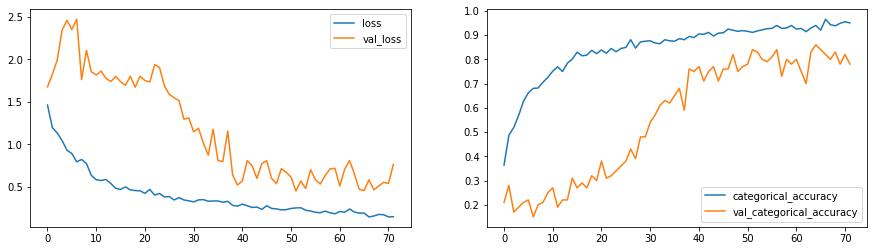

In [ ]:
plot_results(history5)

#### Model 11: CNN + LSTM (Reduced CNN layers)

In [ ]:
x_dim,y_dim = 120,120
model6 = Sequential()
model6.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu'), input_shape=(15,x_dim,y_dim,3)))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(Dropout(0.2))

model6.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2,2))))
model6.add(Dropout(0.2))

model6.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))

model6.add(TimeDistributed(GlobalAveragePooling2D()))

model6.add(LSTM(64))
model6.add(Dense(64, activation='relu'))
model6.add(Dense(32, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(5, activation='softmax'))

In [ ]:
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_57 (TimeDi  (None, 15, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 15, 120, 120, 32)  128      
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 15, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 dropout_19 (Dropout)        (None, 15, 60, 60, 32)    0         
                                                                 
 time_distributed_60 (TimeDi  (None, 15, 60, 60, 64)   18496     
 stributed)                                           

In [ ]:
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
num_epochs = 80
x_dims,y_dims = 120,120
batch_size = 32
callback_list = callback_defination('model6_cnn_lstm_cnn_reduced')
##generator 
train_generator = generator(train_path,data_train, batch_size,x_dims,y_dims)
val_generator = generator(val_path, data_test, batch_size,x_dims,y_dims)



In [ ]:

history6 = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callback_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/iiit-b assigments/gesture recognition/Project_data/train ; batch size = 32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/80
21/21 [==============================] - ETA: 0s - loss: 1.3961 - categorical_accuracy: 0.3816Source path =  /content/drive/MyDrive/iiit-b assigments/gesture recognition/Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.66052, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 62s 3s/step - loss: 1.3961 - categorical_accuracy: 0.3816 - val_loss: 1.6605 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/80
21/21 [==============================] - ETA: 0s - loss: 1.1866 - categorical_accuracy: 0.4796
Epoch 2: val_loss did not improve from 1.66052
21/21 [==============================] - 52s 3s/step - loss: 1.1866 - categorical_accuracy: 0.4796 - val_loss: 1.7517 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/80
21/21 [==============================] - ETA: 0s - loss: 1.0371 - categorical_accuracy: 0.5385
Epoch 3: val_loss did not improve from 1.66052
21/21 [==============================] - 52s 3s/step - loss: 1.0371 - categorical_accuracy: 0.5385 - val_loss: 1.8865 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 4/80
21/21 [==============================] - ETA: 0s - loss: 0.9615 - categorical_accuracy: 0.5958
Epoch 4: val_loss did not improve from 1.66052
21/21 [==============================] - 51

21/21 [==============================] - 57s 3s/step - loss: 0.4704 - categorical_accuracy: 0.8235 - val_loss: 1.6065 - val_categorical_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 20/80
21/21 [==============================] - ETA: 0s - loss: 0.4529 - categorical_accuracy: 0.8250
Epoch 20: val_loss improved from 1.60647 to 1.55742, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 56s 3s/step - loss: 0.4529 - categorical_accuracy: 0.8250 - val_loss: 1.5574 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 21/80
21/21 [==============================] - ETA: 0s - loss: 0.4479 - categorical_accuracy: 0.8311
Epoch 21: val_loss did not improve from 1.55742
21/21 [==============================] - 52s 3s/step - loss: 0.4479 - categorical_accuracy: 0.8311 - val_loss: 1.6048 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 22/80
21/21 [==============================] - ETA: 0s - loss: 0.4320 - categorical_accuracy: 0.8296
Epoch 22: val_loss did not improve from 1.55742
21/21 [==============================] - 53s 3s/step - loss: 0.4320 - categorical_accuracy: 0.8296 - val_loss: 1.6076 - val_categorical_accuracy: 0.3700 - lr: 1.0000e-04
Epoch 23/80
21/21 [==============================] - ETA: 0s - loss: 0.4201 - categorical_accuracy: 0.8356
Epoch 23: val_loss did not improve from 1.55742
21/21 [==================

21/21 [==============================] - 56s 3s/step - loss: 0.4166 - categorical_accuracy: 0.8371 - val_loss: 1.4773 - val_categorical_accuracy: 0.4300 - lr: 1.0000e-04
Epoch 25/80
21/21 [==============================] - ETA: 0s - loss: 0.4417 - categorical_accuracy: 0.8100
Epoch 25: val_loss improved from 1.47734 to 1.35655, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 57s 3s/step - loss: 0.4417 - categorical_accuracy: 0.8100 - val_loss: 1.3565 - val_categorical_accuracy: 0.4400 - lr: 1.0000e-04
Epoch 26/80
21/21 [==============================] - ETA: 0s - loss: 0.4116 - categorical_accuracy: 0.8446
Epoch 26: val_loss improved from 1.35655 to 1.28437, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 57s 3s/step - loss: 0.4116 - categorical_accuracy: 0.8446 - val_loss: 1.2844 - val_categorical_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 27/80
21/21 [==============================] - ETA: 0s - loss: 0.4232 - categorical_accuracy: 0.8356
Epoch 27: val_loss improved from 1.28437 to 1.27719, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 57s 3s/step - loss: 0.4232 - categorical_accuracy: 0.8356 - val_loss: 1.2772 - val_categorical_accuracy: 0.4600 - lr: 1.0000e-04
Epoch 28/80
21/21 [==============================] - ETA: 0s - loss: 0.4131 - categorical_accuracy: 0.8477
Epoch 28: val_loss improved from 1.27719 to 1.19288, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 55s 3s/step - loss: 0.4131 - categorical_accuracy: 0.8477 - val_loss: 1.1929 - val_categorical_accuracy: 0.5100 - lr: 1.0000e-04
Epoch 29/80
21/21 [==============================] - ETA: 0s - loss: 0.3886 - categorical_accuracy: 0.8477
Epoch 29: val_loss did not improve from 1.19288
21/21 [==============================] - 52s 3s/step - loss: 0.3886 - categorical_accuracy: 0.8477 - val_loss: 1.2432 - val_categorical_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 30/80
21/21 [==============================] - ETA: 0s - loss: 0.3895 - categorical_accuracy: 0.8597
Epoch 30: val_loss did not improve from 1.19288
21/21 [==============================] - 53s 3s/step - loss: 0.3895 - categorical_accuracy: 0.8597 - val_loss: 1.2151 - val_categorical_accuracy: 0.5200 - lr: 1.0000e-04
Epoch 31/80
21/21 [==============================] - ETA: 0s - loss: 0.3709 - categorical_accuracy: 0.8386
Epoch 31: val_loss improved from 1.19288 to 1.08750, saving model to /con

21/21 [==============================] - 58s 3s/step - loss: 0.3709 - categorical_accuracy: 0.8386 - val_loss: 1.0875 - val_categorical_accuracy: 0.5800 - lr: 1.0000e-04
Epoch 32/80
21/21 [==============================] - ETA: 0s - loss: 0.3971 - categorical_accuracy: 0.8416
Epoch 32: val_loss improved from 1.08750 to 1.00370, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 55s 3s/step - loss: 0.3971 - categorical_accuracy: 0.8416 - val_loss: 1.0037 - val_categorical_accuracy: 0.5800 - lr: 1.0000e-04
Epoch 33/80
21/21 [==============================] - ETA: 0s - loss: 0.3685 - categorical_accuracy: 0.8688
Epoch 33: val_loss improved from 1.00370 to 0.96930, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 57s 3s/step - loss: 0.3685 - categorical_accuracy: 0.8688 - val_loss: 0.9693 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 34/80
21/21 [==============================] - ETA: 0s - loss: 0.3720 - categorical_accuracy: 0.8492
Epoch 34: val_loss did not improve from 0.96930
21/21 [==============================] - 53s 3s/step - loss: 0.3720 - categorical_accuracy: 0.8492 - val_loss: 1.1613 - val_categorical_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 35/80
21/21 [==============================] - ETA: 0s - loss: 0.3830 - categorical_accuracy: 0.8522
Epoch 35: val_loss improved from 0.96930 to 0.77966, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 58s 3s/step - loss: 0.3830 - categorical_accuracy: 0.8522 - val_loss: 0.7797 - val_categorical_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 36/80
21/21 [==============================] - ETA: 0s - loss: 0.3993 - categorical_accuracy: 0.8341
Epoch 36: val_loss improved from 0.77966 to 0.75888, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 56s 3s/step - loss: 0.3993 - categorical_accuracy: 0.8341 - val_loss: 0.7589 - val_categorical_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 37/80
21/21 [==============================] - ETA: 0s - loss: 0.3341 - categorical_accuracy: 0.8733
Epoch 37: val_loss improved from 0.75888 to 0.63668, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 57s 3s/step - loss: 0.3341 - categorical_accuracy: 0.8733 - val_loss: 0.6367 - val_categorical_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 38/80
21/21 [==============================] - ETA: 0s - loss: 0.3318 - categorical_accuracy: 0.8718
Epoch 38: val_loss did not improve from 0.63668
21/21 [==============================] - 52s 3s/step - loss: 0.3318 - categorical_accuracy: 0.8718 - val_loss: 0.7741 - val_categorical_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 39/80
21/21 [==============================] - ETA: 0s - loss: 0.3465 - categorical_accuracy: 0.8673
Epoch 39: val_loss improved from 0.63668 to 0.56216, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model6_cnn_lstm_cnn_reduced


21/21 [==============================] - 58s 3s/step - loss: 0.3465 - categorical_accuracy: 0.8673 - val_loss: 0.5622 - val_categorical_accuracy: 0.6700 - lr: 1.0000e-04
Epoch 40/80
21/21 [==============================] - ETA: 0s - loss: 0.3381 - categorical_accuracy: 0.8643
Epoch 40: val_loss did not improve from 0.56216
21/21 [==============================] - 50s 3s/step - loss: 0.3381 - categorical_accuracy: 0.8643 - val_loss: 0.6992 - val_categorical_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 41/80
21/21 [==============================] - ETA: 0s - loss: 0.3453 - categorical_accuracy: 0.8567
Epoch 41: val_loss did not improve from 0.56216
21/21 [==============================] - 53s 3s/step - loss: 0.3453 - categorical_accuracy: 0.8567 - val_loss: 0.6877 - val_categorical_accuracy: 0.6900 - lr: 1.0000e-04
Epoch 42/80
21/21 [==============================] - ETA: 0s - loss: 0.3462 - categorical_accuracy: 0.8582
Epoch 42: val_loss did not improve from 0.56216
21/21 [==================

21/21 [==============================] - 58s 3s/step - loss: 0.2697 - categorical_accuracy: 0.8959 - val_loss: 0.3989 - val_categorical_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 55/80
21/21 [==============================] - ETA: 0s - loss: 0.3031 - categorical_accuracy: 0.8839
Epoch 55: val_loss did not improve from 0.39885
21/21 [==============================] - 52s 3s/step - loss: 0.3031 - categorical_accuracy: 0.8839 - val_loss: 0.7679 - val_categorical_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 56/80
21/21 [==============================] - ETA: 0s - loss: 0.2847 - categorical_accuracy: 0.8869
Epoch 56: val_loss did not improve from 0.39885
21/21 [==============================] - 51s 3s/step - loss: 0.2847 - categorical_accuracy: 0.8869 - val_loss: 0.5765 - val_categorical_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 57/80
21/21 [==============================] - ETA: 0s - loss: 0.3136 - categorical_accuracy: 0.8808
Epoch 57: val_loss did not improve from 0.39885
21/21 [==================

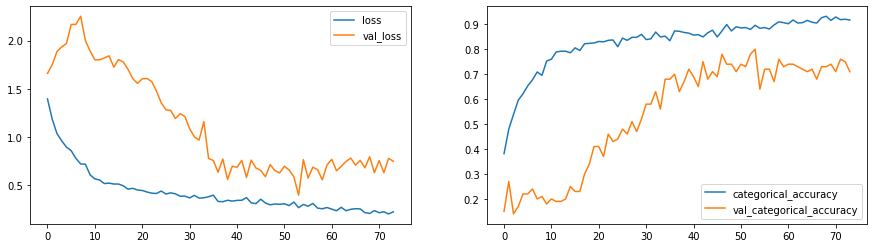

In [ ]:
plot_results(history6)

#### Model 12: VGG16 + GRU


In [ ]:
pretrained_vgg = tf.keras.applications.VGG16(
                                                include_top=False,
                                                weights="imagenet",
                                              )
model9 = Sequential()
model9.add(TimeDistributed(pretrained_vgg, input_shape=(15,120,120,3)))
  
for layer in model9.layers:
    layer.trainable = False

model9.add(TimeDistributed(BatchNormalization()))
# model9.add(TimeDistributed(MaxPooling2D((2, 2))))
model9.add(TimeDistributed(GlobalAveragePooling2D()))
model9.add(Dropout(0.2))

model9.add(GRU(128))
model9.add(Dense(64, activation='relu'))
model9.add(Dense(32, activation='relu'))
model9.add(Dropout(0.2))
model9.add(Dense(5, activation='softmax'))






58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 3, 3, 512)    14714688  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 3, 3, 512)    2048      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 512)          0         
 tributed)                                                       
                                                                 
 dropout (Dropout)           (None, 15, 512)           0         
                                                                 
 gru (GRU)                   (None, 128)               246528    
                                                        

In [ ]:
model9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
num_epochs = 80
x_dims,y_dims = 120,120
batch_size = 32
callback_list = callback_defination('model9_cnn_gru_vgg16_120')
##generator 
train_generator = generator(train_path,data_train, batch_size,x_dims,y_dims)
val_generator = generator(val_path, data_test, batch_size,x_dims,y_dims)

In [ ]:
if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:

history9 = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callback_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Source path =  /content/drive/MyDrive/iiit-b assigments/gesture recognition/Project_data/train ; batch size = 32
Epoch 1/80
21/21 [==============================] - ETA: 0s - loss: 1.4626 - categorical_accuracy: 0.3635  Source path =  /content/drive/MyDrive/iiit-b assigments/gesture recognition/Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.53025, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 6974s 348s/step - loss: 1.4626 - categorical_accuracy: 0.3635 - val_loss: 1.5302 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/80
21/21 [==============================] - ETA: 0s - loss: 1.0632 - categorical_accuracy: 0.5928
Epoch 2: val_loss improved from 1.53025 to 1.24731, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 59s 3s/step - loss: 1.0632 - categorical_accuracy: 0.5928 - val_loss: 1.2473 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 3/80
21/21 [==============================] - ETA: 0s - loss: 0.7360 - categorical_accuracy: 0.7119
Epoch 3: val_loss improved from 1.24731 to 1.08935, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 57s 3s/step - loss: 0.7360 - categorical_accuracy: 0.7119 - val_loss: 1.0894 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 4/80
21/21 [==============================] - ETA: 0s - loss: 0.5352 - categorical_accuracy: 0.8084
Epoch 4: val_loss improved from 1.08935 to 1.08673, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 56s 3s/step - loss: 0.5352 - categorical_accuracy: 0.8084 - val_loss: 1.0867 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 5/80
21/21 [==============================] - ETA: 0s - loss: 0.3431 - categorical_accuracy: 0.8854
Epoch 5: val_loss improved from 1.08673 to 1.02578, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 59s 3s/step - loss: 0.3431 - categorical_accuracy: 0.8854 - val_loss: 1.0258 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 6/80
21/21 [==============================] - ETA: 0s - loss: 0.2236 - categorical_accuracy: 0.9216
Epoch 6: val_loss improved from 1.02578 to 0.93488, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 58s 3s/step - loss: 0.2236 - categorical_accuracy: 0.9216 - val_loss: 0.9349 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 7/80
21/21 [==============================] - ETA: 0s - loss: 0.2125 - categorical_accuracy: 0.9427
Epoch 7: val_loss did not improve from 0.93488
21/21 [==============================] - 52s 3s/step - loss: 0.2125 - categorical_accuracy: 0.9427 - val_loss: 0.9957 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 8/80
21/21 [==============================] - ETA: 0s - loss: 0.1145 - categorical_accuracy: 0.9789
Epoch 8: val_loss improved from 0.93488 to 0.92627, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 56s 3s/step - loss: 0.1145 - categorical_accuracy: 0.9789 - val_loss: 0.9263 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 9/80
21/21 [==============================] - ETA: 0s - loss: 0.0867 - categorical_accuracy: 0.9759
Epoch 9: val_loss improved from 0.92627 to 0.82768, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 57s 3s/step - loss: 0.0867 - categorical_accuracy: 0.9759 - val_loss: 0.8277 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 10/80
21/21 [==============================] - ETA: 0s - loss: 0.1028 - categorical_accuracy: 0.9653
Epoch 10: val_loss did not improve from 0.82768
21/21 [==============================] - 52s 3s/step - loss: 0.1028 - categorical_accuracy: 0.9653 - val_loss: 1.1235 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 11/80
21/21 [==============================] - ETA: 0s - loss: 0.0818 - categorical_accuracy: 0.9774
Epoch 11: val_loss improved from 0.82768 to 0.81501, saving model to /content/drive/MyDrive/iiit-b assigments/gesture recognition/model_trained/model9_cnn_gru_vgg16_120


21/21 [==============================] - 58s 3s/step - loss: 0.0818 - categorical_accuracy: 0.9774 - val_loss: 0.8150 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 12/80
21/21 [==============================] - ETA: 0s - loss: 0.0420 - categorical_accuracy: 0.9940
Epoch 12: val_loss did not improve from 0.81501
21/21 [==============================] - 50s 2s/step - loss: 0.0420 - categorical_accuracy: 0.9940 - val_loss: 0.8388 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 13/80
21/21 [==============================] - ETA: 0s - loss: 0.0407 - categorical_accuracy: 0.9910
Epoch 13: val_loss did not improve from 0.81501
21/21 [==============================] - 52s 3s/step - loss: 0.0407 - categorical_accuracy: 0.9910 - val_loss: 0.8702 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 14/80
21/21 [==============================] - ETA: 0s - loss: 0.0489 - categorical_accuracy: 0.9864
Epoch 14: val_loss did not improve from 0.81501
21/21 [==============================

21/21 [==============================] - 59s 3s/step - loss: 0.0550 - categorical_accuracy: 0.9819 - val_loss: 0.6787 - val_categorical_accuracy: 0.7900 - lr: 0.0010
Epoch 16/80
21/21 [==============================] - ETA: 0s - loss: 0.0317 - categorical_accuracy: 0.9894
Epoch 16: val_loss did not improve from 0.67869
21/21 [==============================] - 49s 2s/step - loss: 0.0317 - categorical_accuracy: 0.9894 - val_loss: 1.1631 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 17/80
21/21 [==============================] - ETA: 0s - loss: 0.0429 - categorical_accuracy: 0.9819
Epoch 17: val_loss did not improve from 0.67869
21/21 [==============================] - 51s 3s/step - loss: 0.0429 - categorical_accuracy: 0.9819 - val_loss: 0.7844 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 18/80
21/21 [==============================] - ETA: 0s - loss: 0.0419 - categorical_accuracy: 0.9910
Epoch 18: val_loss did not improve from 0.67869
21/21 [==============================

## Conclusion
After building and training all the models, we would like to select Model #5 which is CNN + GRU due to the following reasons:
- Training Accuracy – 86% & Validation Accuracy – 84%
- Number of parameters are 99,845 which is suitable for edge devices because the model will consume less memory.
- The model seems to generalize well.
